In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import numpy as np

'''
filename
fifa_2018_results.csv
fifa_2018_results_updated_20180708.csv
fifa_2018_stats.csv
past_results.csv
players_scores.csv
sofifa.csv
'''

#Preparing data

data = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data.head()

data_home = data.groupby('home_team', as_index = False).agg({"home_result": np.sum})
data_away = data.groupby('away_team', as_index = False).agg({"away_result": np.sum})

data = data_home.rename( columns = {'home_team' : 'team'})
data['away_result'] = data_away['away_result']
data['total_score'] = data['away_result'] + data['home_result'] 
data

,team,home_result,away_result,total_score
0,Argentina,1,5,6
1,Australia,0,2,2
2,Belgium,11,3,14
3,Brazil,6,2,8
4,Colombia,2,4,6
5,Costa Rica,0,2,2
6,Croatia,3,7,10
7,Denmark,1,2,3
8,Egypt,0,2,2
9,England,6,5,11


In [126]:
sofifa = pd.read_csv('dataset/sofifa1.csv') #only the latest stat
sofifa.rename(columns = {'countrystats' : 'team'} , inplace = True)
sofifa.head()

data_new = pd.read_csv('dataset/fifa_2018_results_updated_20180708.csv')
data1 = data_new.join(sofifa.set_index('team'), on = 'home_team')
data1 = data1.join(sofifa.add_suffix('_opponent').set_index('team_opponent'), on = 'away_team')

data1 = data1.drop(columns=['game','away_team','away_result','home_penalty','away_penalty','lat','long','stadium' ,'country','city','datestats','bu_positioning','cc_positioning','datestats_opponent','bu_positioning_opponent','cc_positioning_opponent'])
data1 = data1.rename( columns = {'home_team': 'team','home_result' : 'result'})

data2 = data_new.join(sofifa.set_index('team'), on = 'away_team')
data2 = data2.join(sofifa.add_suffix('_opponent').set_index('team_opponent'), on = 'home_team')

data2 = data2.drop(columns=['game','home_team','home_result','home_penalty','away_penalty','lat','long','stadium' ,'country','city','datestats','bu_positioning','cc_positioning','datestats_opponent','bu_positioning_opponent','cc_positioning_opponent'])
data2 = data2.rename( columns = {'away_team': 'team','away_result' : 'result'})

pd.options.display.max_rows = 200
data_new = data1.append(data2 , ignore_index = True)
data_new = data_new.dropna()
#data_new

#Final data
fr = sofifa[sofifa['team'] == 'France'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)
cr = sofifa[sofifa['team'] == 'Croatia'].drop(columns = ['datestats','bu_positioning','cc_positioning']).reset_index(drop=True)

data_predict = fr.join( cr.drop(columns = 'team').add_suffix('_opponent'))
data_predict = data_predict.append(cr.join(fr.drop(columns = 'team').add_suffix('_opponent')), ignore_index = True)
data_predict.drop(columns ='team', inplace = True)
data_predict

,overall,attack,midfield,defense,bu_speed,bu_passing,cc_crossing,cc_passing,cc_shooting,aggression,...,midfield_opponent,defense_opponent,bu_speed_opponent,bu_passing_opponent,cc_crossing_opponent,cc_passing_opponent,cc_shooting_opponent,aggression_opponent,pressure_opponent,avg_age_opponent
0,84,83,85,82,35,30,53,24,35,47,...,78,74,59,44,74,39,61,61,61,26.64
1,78,78,78,74,59,44,74,39,61,61,...,85,82,35,30,53,24,35,47,47,25.65


In [ ]:


ht = np.array(data['team'])
hs = np.array(data['home_result'])
at = np.array(data['team'])
away_s = np.array(data['away_result'])

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(ht,hs, label = 'Home Score')
plt.xticks(ht,  rotation='vertical')
plt.title('Home Score')
plt.xlabel('Team')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(at,away_s, label = 'Away Score', color ='c')
plt.xticks(at,  rotation='vertical')
plt.title('Away Score')
plt.xlabel('Team')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(data['team'],data['total_score'], label = 'Score', color ='y')
plt.xticks(data['team'],  rotation='vertical')
plt.title('Total Score')
plt.xlabel('Team')
plt.ylabel('Score')
plt.legend()
plt.show()

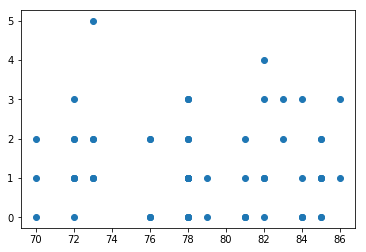

In [5]:
plt.scatter(data_new['overall_opponent'], data_new['result'])
plt.show()



In [97]:
#Feature Extraction
from sklearn.decomposition import PCA, KernelPCA

def PCA_Transformer(PCA_data):    
    PCA_data = np.array(PCA_data)
    pca =PCA(n_components =24)
    pca.fit(PCA_data)
    #pca.fit_transform(PCA_data)
    X = pca.transform(PCA_data)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)  
    print(X.size)
    
    return X


In [128]:
X_train = data_new.drop(columns = ['date','team','result'])
X = PCA_Transformer(X_train)

[2.46332026e-01 2.38870602e-01 1.17168050e-01 8.24677814e-02
 6.50859972e-02 5.73722345e-02 4.05404686e-02 3.43463122e-02
 3.19383165e-02 2.66338191e-02 2.35634116e-02 1.74020755e-02
 4.82376839e-03 4.80703778e-03 2.72454251e-03 2.12585975e-03
 1.22974164e-03 1.15597614e-03 4.86367930e-04 4.44627989e-04
 2.35362394e-04 1.51997800e-04 4.82779649e-05 4.53457715e-05]
[201.47567396 198.40085063 138.95263259 116.57470725 103.56331884
  97.2328601   81.73471639  75.23193541  72.54678794  66.24893494
  62.31337344  53.55039792  28.19391602  28.1449801   21.18892737
  18.71670878  14.23538173  13.80182809   8.95250647   8.55974007
   6.22774347   5.00473204   2.82056853   2.73357237]
1728


In [100]:
y = data_new['result']

In [138]:
#Modelling
from sklearn.neural_network import MLPClassifier
# clf =  MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
#                      beta_1=0.9, beta_2=0.999, early_stopping=False,
#                      epsilon=1e-08, hidden_layer_sizes=(5, 2), learning_rate='constant',
#                      learning_rate_init=0.001, max_iter=200,random_state=1, shuffle=True,
#                      solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
#                      warm_start=False)
clf = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                   beta_1=0.9, beta_2=0.999, early_stopping=False,
                   epsilon=1e-08, hidden_layer_sizes=(5, 2), learning_rate='constant',
                   learning_rate_init=0.001, max_iter=200, momentum=0.9,
                   nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
                   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
                   warm_start=False)
a = clf.fit(X, y)

In [141]:
clf.predict(data_predict)

array([1, 0], dtype=int64)